In [1]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import pickle
import os
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import plotly.express as px

headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'}

pd.options.display.max_columns=300

In [ ]:
urls=[]
for i in range(1, 620001):
    id=500000000+i
    url=f'https://www.x.com/stats/{id}'
    urls.append(url)

In [ ]:
def return_dict(url):

    try:
        html=requests.get(url,headers).content
        soup=BeautifulSoup(html)
    except:
        pass

    try:
        nickname=soup.select_one('div[id="x"] h1').text
    except:
        nickname=None

    try:
        country=soup.select_one('div[id="x"] h1 img')['src']
    except:
        country=None

    try:
        rank=soup.select_one('td[rowspan="2"] div:nth-child(2)').text
    except:
        rank=None

    try:
        progress_details={e.select_one('div[class="x"]').text:e.select_one('div[class="x"]').text for e in soup.select('table[cellpadding="0"] tr td[style="text-align:center"]')}
    except:
        progress_details=None

    try:
        details=[e.get_text(separator=' ').strip() for e in soup.select('div[class="x"] table tr')]
    except:
        details=None

    try:
        transport_details_df=pd.read_html(html)[4]
    except:
        transport_details_df=None

    try:
        class_details_df=pd.read_html(html)[5]
    except:
        class_details_df=None

    try:
        weapons_details_df=pd.read_html(html)[6]
    except:
        weapons_details_df=None

    try:
        team_details_df=pd.read_html(html)[7]
    except:
        team_details_df=None

    dict={'URL':url,'Nickname':nickname,'Country':country,'Rank':rank,'Progress Details':progress_details,'Details':details,'Transport Details':transport_details_df,'Class Details':class_details_df,'Weapons Details':weapons_details_df,'Team Details':team_details_df}
    return dict


In [ ]:
max_index=0
for file in os.listdir('scraped_data'):
    index=int(file.split('_')[-1])
    if index>max_index:
        max_index=index
max_index

In [ ]:
all_data=[]
for i, url in enumerate(urls,start=1):
    if i<=max_index:
        continue
    
    dict=return_dict(url)
    all_data.append(dict)

    if i%1000==0 or i==len(urls):
        pickle.dump(all_data, open(f'scraped_data/all_data_{i}','wb'))
        all_data=[]

    print(f'{i}/{len(urls)}',end='\r')


In [ ]:
all=[]
for i, file in enumerate(os.listdir('scraped_data'),start=1):
    data=pickle.load(open(os.path.join('scraped_data',file),'rb'))
    all.extend(data)
    print(i,end='\r')

pickle.dump(all, open('all_data.pickle','wb'))

In [2]:
df=pd.read_csv('bf2.csv')

C:\Users\berid\AppData\Local\Temp\ipykernel_13856\4236195413.py:1: DtypeWarning: Columns (17,18,19,21,22,27,28) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv('bf2.csv')


In [3]:
df.columns=df.columns.str.strip()

In [4]:
#kaggle_df=df.drop(columns='URL').to_csv('bf2_df.csv',index=False)

In [5]:
grouped = df.groupby('Country')['URL'].count().reset_index().reset_index()
grouped.loc[grouped['Country'] == 'UK', 'Country'] = 'GB'

import pycountry

def iso2_to_iso3(iso2):
    try:
        return pycountry.countries.get(alpha_2=iso2).alpha_3
    except AttributeError:
        return None 

grouped['ISO3'] = grouped['Country'].apply(iso2_to_iso3) 

fig = px.choropleth(grouped, locations='ISO3', locationmode='ISO-3', color='URL',color_continuous_scale='Reds')
fig.update_traces(marker_line_width=0.1)
fig.update_layout(template='plotly_dark',margin=dict(l=0, r=0, t=25, b=0))
fig.update_layout(title=dict(text='Number of Enlisted Players Since 2014 By Country',font_family='Arial Black'))
fig.show()


In [6]:
df['Global_Enlisted'] = pd.to_datetime(df['Global_Enlisted']).dt.date
df['Global_Enlisted'] = pd.to_datetime(df['Global_Enlisted'])

df['Global_Last Battle'] = pd.to_datetime(df['Global_Last Battle']).dt.date
df['Global_Last Battle'] = pd.to_datetime(df['Global_Last Battle'])

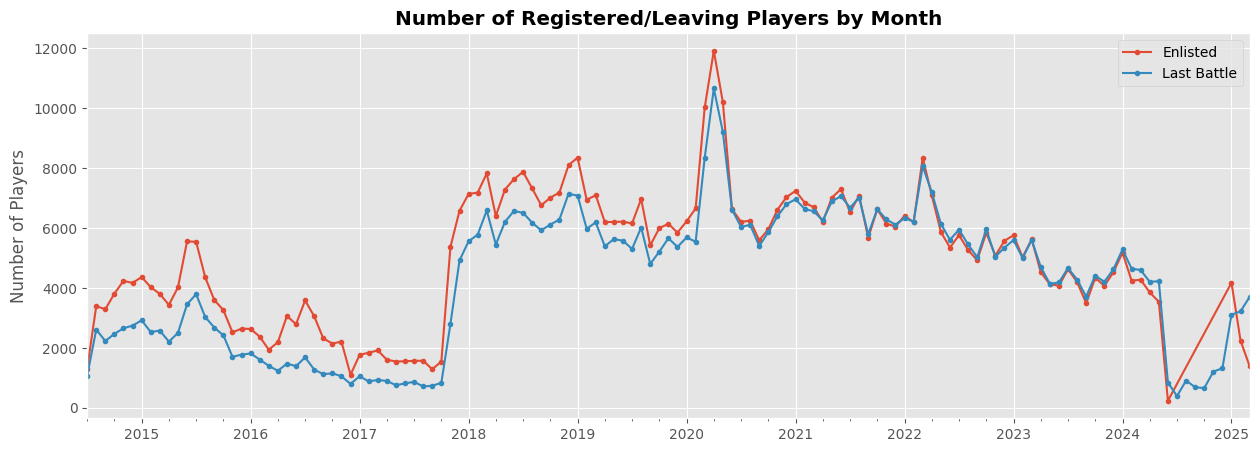

In [7]:
plt.figure(figsize=(15,5))
df.groupby(df['Global_Enlisted'].dt.to_period('M'))['URL'].count().plot.line(marker='.',label='Enlisted')
df.groupby(df['Global_Last Battle'].dt.to_period('M'))['URL'].count().plot.line(marker='.',label='Last Battle')
plt.title('Number of Registered/Leaving Players by Month',fontweight='bold')
plt.xlabel(None)
plt.ylabel('Number of Players')
plt.legend()
plt.show()

In [8]:
df.groupby(df['Global_Enlisted'].dt.to_period('D'))['URL'].count().sort_values(ascending=False).head(10)

#top 10 days by number of enlisted players

Global_Enlisted
2025-01-18    2540
2020-03-22     530
2020-03-29     491
2020-04-04     484
2020-03-28     477
2020-03-27     470
2020-04-05     459
2020-04-02     458
2020-04-18     449
2020-04-19     435
Freq: D, Name: URL, dtype: int64

In [9]:
df['Days Been Active']=((df['Global_Last Battle']-df['Global_Enlisted']).dt.days)

#share of players that had last battle on the same day they enlisted
df[df['Days Been Active']==0].shape[0]/df.shape[0]

0.5835981301582611

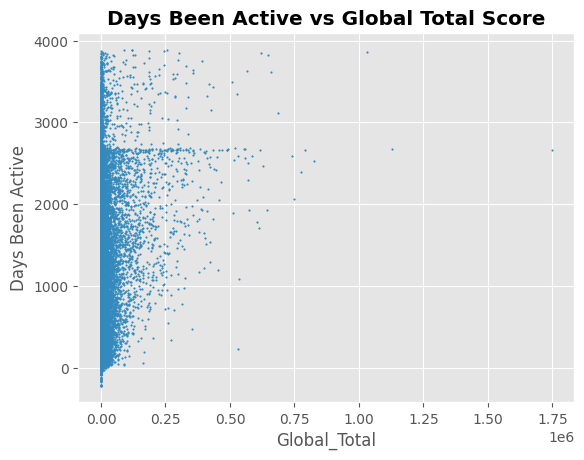

In [10]:
df['Global_Total']=df['Global_Total'].str.replace(',','').astype(int)


df.plot.scatter(x='Global_Total',y='Days Been Active',s=1)
plt.title('Days Been Active vs Global Total Score',fontweight='bold')
plt.show()

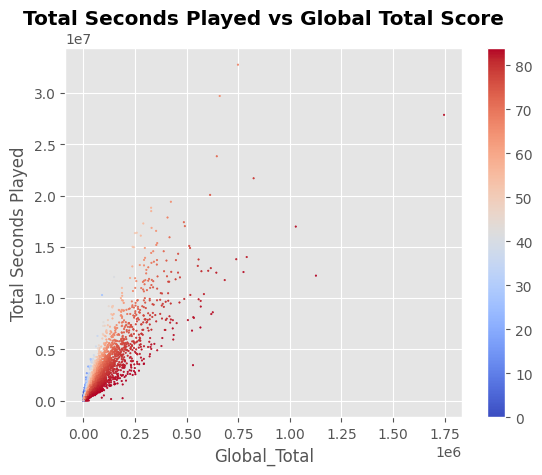

In [11]:
df['Total Seconds Played']=df['Time Stats_Total'].apply(lambda x:x.split('(')[0]).apply(lambda x:int(x.split(':')[0])*3600+int(x.split(':')[1])*60+int(x.split(':')[2]))

df.plot.scatter(x='Global_Total',y='Total Seconds Played',
                s=1,
                c=pd.qcut(df['Global_Total']/df['Total Seconds Played'],q=100,labels=False,duplicates='drop'),cmap='coolwarm')
plt.title('Total Seconds Played vs Global Total Score',fontweight='bold')
plt.show()

In [12]:
class_df=df.filter(like='_Time').iloc[:,:7]

for col in class_df:
    class_df[col]=class_df[col].apply(lambda x:int(x.split(':')[0])*3600+int(x.split(':')[1])*60+int(x.split(':')[2]))

In [13]:
class_df = class_df.div(class_df.sum(axis=1), axis=0)

In [14]:
class_df=class_df.dropna(how='all')

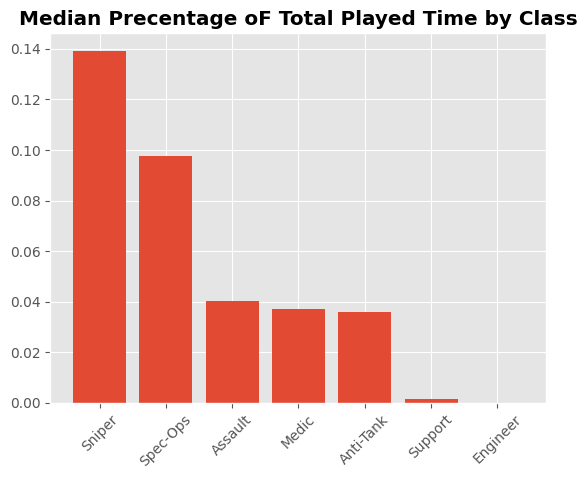

In [15]:
class_dict={}
for class_ in class_df.columns:
    median_percentage_of_total_tiem_played=class_df[class_].median()
    class_dict[class_]=median_percentage_of_total_tiem_played

class_dict = dict(sorted(class_dict.items(), key=lambda item: item[1],reverse=True))

plt.bar(x=[i.split('_')[0] for i in class_dict.keys()],height=class_dict.values())
plt.title('Median Precentage oF Total Played Time by Class',fontweight='bold')
plt.xticks(rotation=45)
plt.show()

#most popular classes are sniper and spec-ops

## KDR

In [16]:
df['Kills_Total']=df['Kills_Total'].str.replace(',','').apply(pd.to_numeric)
df['Deaths_Total']=df['Deaths_Total'].str.replace(',','').apply(pd.to_numeric)

df['KDR']=df['Kills_Total']/df['Deaths_Total']

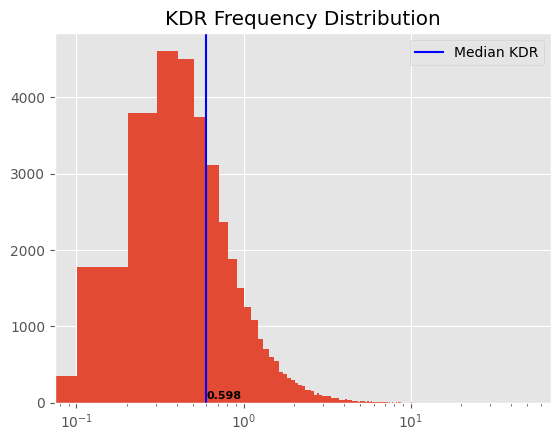

In [17]:
median_kdr=df.query('`Total Seconds Played`>36000')['KDR'].median()
df.query('`Total Seconds Played`>36000')['KDR'].hist(bins=500)
plt.axvline(median_kdr,color='blue',label='Median KDR')
plt.text(median_kdr,50,median_kdr.round(3),fontweight='bold',size=8)
plt.xscale('log')
plt.legend()
plt.title('KDR Frequency Distribution')
plt.show()

In [18]:
filtered=df.query('`Total Seconds Played`>36000')[df.query('`Total Seconds Played`>36000')['KDR']>=10]
filtered.sort_values('Global_Last Battle',ascending=False)[['Nickname','KDR','Days Been Active','Global_Enlisted', 'Global_Last Battle']]

#list of "suspicious" players considering their KDR metric

,Nickname,KDR,Days Been Active,Global_Enlisted,Global_Last Battle
572965,`wN`,11.026823,10.0,2025-02-24,2025-03-06
284744,Tomy***,10.101064,1430.0,2020-09-09,2024-08-09
309808,alpenfrost,12.053232,1306.0,2020-12-25,2024-07-23
499225,((^_^)),21.117647,394.0,2023-04-23,2024-05-21
548744,ClayDoh,11.071429,63.0,2024-03-12,2024-05-14
481539,n0D34tH5,13.979592,258.0,2023-01-22,2023-10-07
491560,Eetwidomayloh,16.429463,78.0,2023-03-14,2023-05-31
487179,NumbcallV2,10.395349,23.0,2023-02-17,2023-03-12
342628,HumptyHump,10.000000,271.0,2021-05-05,2022-01-31
342767,jjjjjjjj222,26.580153,150.0,2021-05-06,2021-10-03


Text(0, 0.5, 'KDR')

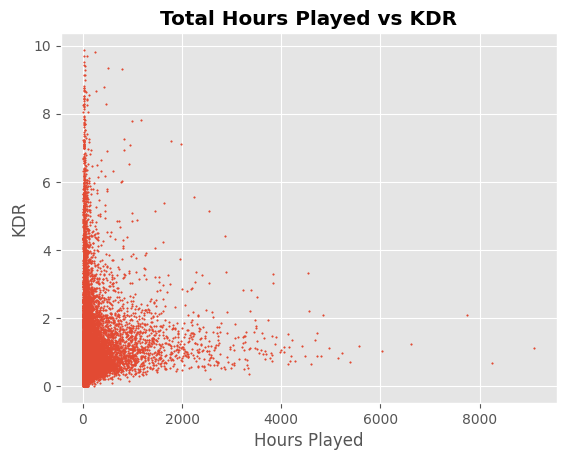

In [19]:
filtered=df.query('`Total Seconds Played`>36000 and KDR<10')
plt.scatter(x=filtered['Total Seconds Played']/3600,y=filtered['KDR'],s=1)
plt.title('Total Hours Played vs KDR',fontweight='bold')
plt.xlabel('Hours Played')
plt.ylabel('KDR')

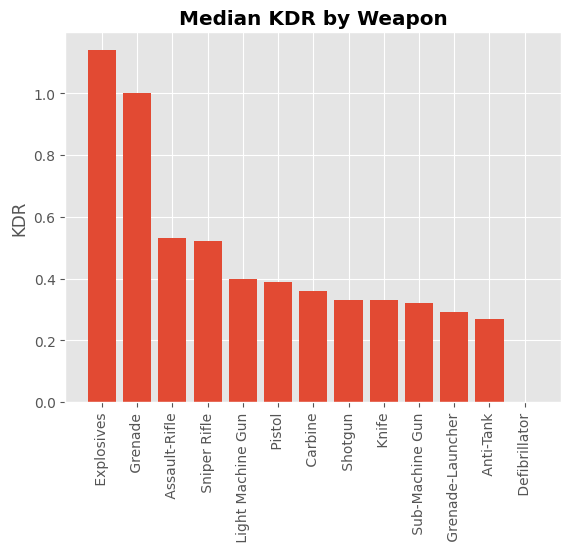

In [20]:
weapons_df=filtered.filter(like='Weapon').filter(like='_KDR')


weapon_dict={}
for col in weapons_df.columns:
    weapon=col.split(')')[-1].split('_')[0]
    medain_kdr=weapons_df[col].median()
    weapon_dict[weapon]=medain_kdr

weapon_dict = dict(sorted(weapon_dict.items(), key=lambda item: item[1],reverse=True))

plt.bar(x=weapon_dict.keys(),height=weapon_dict.values())
plt.title('Median KDR by Weapon',fontweight='bold')
plt.xticks(rotation=90)
plt.ylabel('KDR')
plt.show()

#most effective weapons are explosives, grenades, assault rifles, sniper rifles

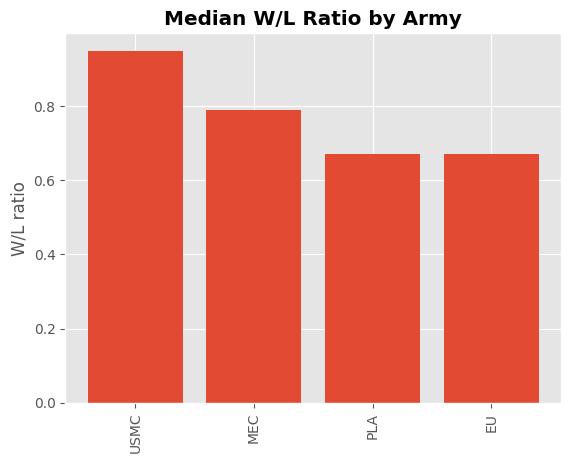

In [21]:
army_df=filtered.filter(like='Army').filter(like='_W/L')

army_dict={}
for col in army_df.columns:
    army=col.split(') ')[-1].split('_')[0]
    if army not in ['USMC','MEC','PLA','EU']:
        continue
    medain_kdr=army_df[col].median()
    army_dict[army]=medain_kdr

army_dict = dict(sorted(army_dict.items(), key=lambda item: item[1],reverse=True))

plt.bar(x=army_dict.keys(),height=army_dict.values())
plt.title('Median W/L Ratio by Army',fontweight='bold')
plt.xticks(rotation=90)
plt.ylabel('W/L ratio')
plt.show()
